In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
dataset = pd.read_csv("/kaggle/input/bbcdataset/BBC News Train.csv")

In [4]:
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
dataset['Text'][0]


'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [6]:
dataset.shape

(1490, 3)

In [7]:
dataset['Category'].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [8]:
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [9]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [10]:
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [11]:
category_to_id = dict(category.values)
id_to_category = dict(category[['CategoryId', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

<Axes: xlabel='Category'>

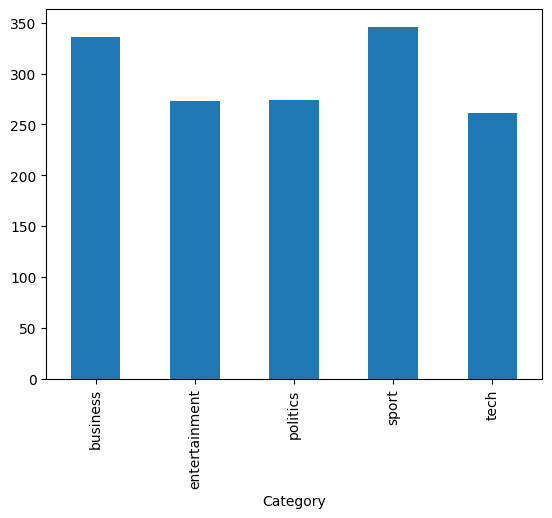

In [12]:
dataset.groupby('Category').CategoryId.count().plot.bar(ylim = 0)

In [13]:
def remove_tags(text):
  remove = re.compile(r'<.*?>')
  return re.sub(remove, '', text)

dataset['Text'] = dataset['Text'].apply(remove_tags)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

In [14]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

dataset['Text'] = dataset['Text'].apply(special_char)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [15]:
def convert_lower(text):
   return text.lower()

dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [16]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]

dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]

['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'february',
 'knocking',
 'hopes',
 'speedy',
 'recovery',
 'europe',
 'largest',
 'economy',
 'munich',
 'based',
 'research',
 'institute',
 'ifo',
 'said',
 'confidence',
 'index',
 'fell',
 '95',
 '5',
 'february',
 '97',
 '5',
 'january',
 'first',
 'decline',
 'three',
 'months',
 'study',
 'found',
 'outlook',
 'manufacturing',
 'retail',
 'sectors',
 'worsened',
 'observers',
 'hoping',
 'confident',
 'business',
 'sector',
 'would',
 'signal',
 'economic',
 'activity',
 'picking',
 'surprised',
 'ifo',
 'index',
 'taken',
 'knock',
 'said',
 'dz',
 'bank',
 'economist',
 'bernd',
 'weidensteiner',
 'main',
 'reason',
 'probably',
 'domestic',
 'economy',
 'still',
 'weak',
 'particularly',
 'retail',
 'trade',
 'economy',
 'labour',
 'minister',
 'wolfgang',
 'clement',
 'called',
 'dip',
 'february',
 'ifo',
 'confidence',
 'figure',
 'mild',
 'decline',
 'said',
 'despite',
 'r

In [18]:
dataset['joined_text'] = dataset['Text'].apply(lambda x: ' '.join(x))

# Display the DataFrame
print(dataset)
     

      ArticleId                                               Text  \
0          1833  [worldcom, ex, boss, launches, defence, lawyer...   
1           154  [german, business, confidence, slides, german,...   
2          1101  [bbc, poll, indicates, economic, gloom, citize...   
3          1976  [lifestyle, governs, mobile, choice, faster, b...   
4           917  [enron, bosses, 168m, payout, eighteen, former...   
...         ...                                                ...   
1485        857  [double, eviction, big, brother, model, capric...   
1486        325  [dj, double, act, revamp, chart, show, dj, duo...   
1487       1590  [weak, dollar, hits, reuters, revenues, media,...   
1488       1587  [apple, ipod, family, expands, market, apple, ...   
1489        538  [santy, worm, makes, unwelcome, visit, thousan...   

           Category  CategoryId  \
0          business           0   
1          business           0   
2          business           0   
3              tech

In [19]:
x = dataset['joined_text']
y = dataset['Category']
     

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.joined_text).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)


print(len(x_train))
print(len(x_test))

1043
447


In [23]:
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   


    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [25]:
perform_list = []

In [26]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 97.09
Precision : 0.970917225950783
Recall    : 0.970917225950783
F1-score   : 0.9709172259507831


In [27]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 97.32
Precision : 0.9731543624161074
Recall    : 0.9731543624161074
F1-score   : 0.9731543624161074


In [28]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [29]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Support Vector Classifer: % 96.2
Precision : 0.9619686800894854
Recall    : 0.9619686800894854
F1-score   : 0.9619686800894854


In [30]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,97.09,0.97,0.97,0.97
1,Random Forest,97.32,0.97,0.97,0.97
2,Multinomial Naive Bayes,97.54,0.98,0.98,0.98
3,Support Vector Classifer,96.20,0.96,0.96,0.96
